# Mona Lisa's smile
This notebook performs 2D spectral image processing on the Mona Lisa to illustrate the use of ***sfumato*** to create the famous "changing" smile.

In [9]:
# imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.exposure as exposure
from skimage.draw import ellipse

# original image from Wikipedia
MONA_LISA = "mona-lisa-C2RMF-retouched.jpg"

# Functions

In [10]:
#-----------------------------------------------------------------------------
def read_img(fname):
    img = cv2.imread(fname)
    img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2RGB)

    return img


#-----------------------------------------------------------------------------
def img2uint8(data):
    # Get min & max value
    minV = np.min(data)
    maxV = np.max(data)
    
    # normalize the data to 0 - 1
    data = (data-minV) / (maxV-minV)
    
    # Now scale by 255
    data = 255 * data 
    
    return data.astype(np.uint8)

#-----------------------------------------------------------------------------
# sample values from a spherical gaussian function from the center of the image
def makeGaussianFilter(numRows, numCols, sigma, highPass=True):
    ctrY = int(numRows/2) + 1 if numRows % 2 == 1 else int(numRows/2)
    ctrX = int(numCols/2) + 1 if numCols % 2 == 1 else int(numCols/2)
    Y, X = np.mgrid[0:numRows, 0:numCols]
    imgFilter = np.exp(-1.0 * ((X - ctrX)**2 + (Y - ctrY)**2) / (2 * sigma**2))

    return 1 - imgFilter if highPass else imgFilter


#-----------------------------------------------------------------------------
def filterDFT(imageMatrix, filterMatrix):
    shiftedDFT = np.fft.fftshift(np.fft.fft2(imageMatrix))
    filteredDFT = shiftedDFT * filterMatrix

    return np.fft.ifft2(np.fft.ifftshift(filteredDFT))


#-----------------------------------------------------------------------------
def lowPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=False))


#-----------------------------------------------------------------------------
def highPass(imageMatrix, sigma):
    n,m = imageMatrix.shape
    
    return filterDFT(imageMatrix, makeGaussianFilter(n, m, sigma, highPass=True))


#-----------------------------------------------------------------------------
def stackGaussian(img, sigmas):

    gaussStack = []

    # full image
    gaussStack.append(img.astype(float))

    # LPF images
    for sigma in sigmas:
        imgLPF = lowPass(img, sigma)
        gaussStack.append(imgLPF.real)


    return np.array(gaussStack)


#-----------------------------------------------------------------------------
def stackLaplacian(img, sigmas):

    laplaceStack = []

    # create gaussian stack
    gaussStack = stackGaussian(img, sigmas)

    # create difference images
    for i, sigma in enumerate(sigmas):
        imgHPF = gaussStack[i] - gaussStack[i+1]
        laplaceStack.append(imgHPF)

    # last stack is most LPF'd image
    laplaceStack.append(gaussStack[-1])

    return np.array(laplaceStack)


#-----------------------------------------------------------------------------
def img_blend(imgA, imgB, mask, wA, wB, sigmas):
    imgAL  = stackLaplacian(imgA, sigmas)
    imgBL  = stackLaplacian(imgB, sigmas)
    maskG  = stackGaussian(mask, sigmas)
    imgC = np.zeros((imgA.shape[0], imgA.shape[1]))
    N    = len(sigmas)+1
    for i in range(0, N):
        imgC += wA[i]*maskG[i]*imgAL[i] + wB[i]*(1-maskG[i])*imgBL[i]
    
    return imgC



# The Masterpiece

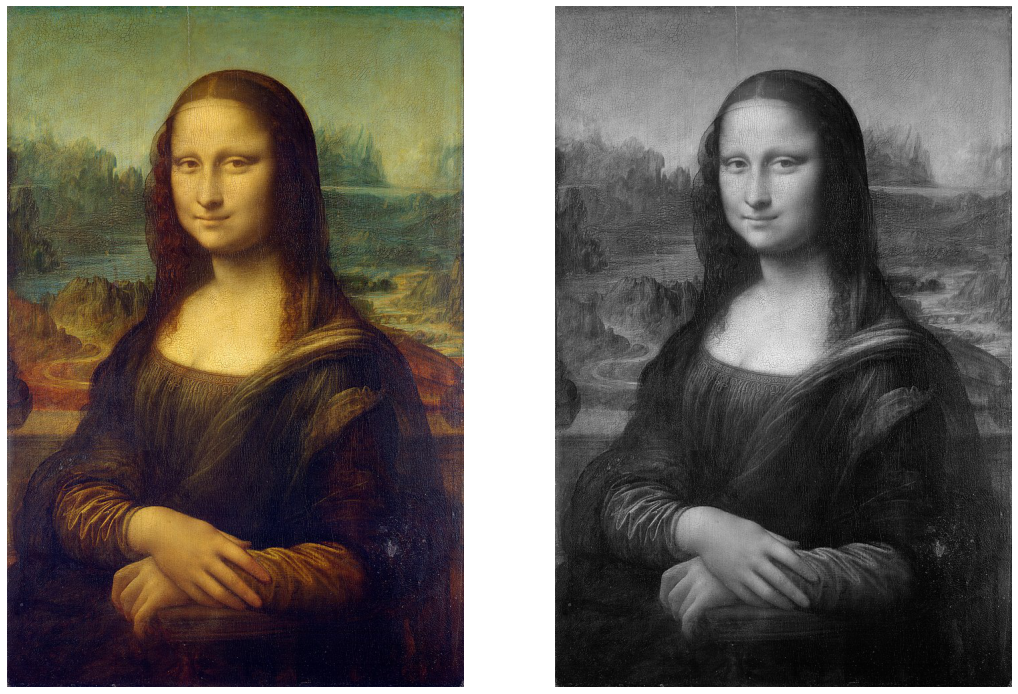

In [11]:
#-----------------------------------------------------------------------------
# get image
#-----------------------------------------------------------------------------
mona_lisa_color = read_img(MONA_LISA)
mona_lisa_gray  = cv2.cvtColor(src=mona_lisa_color, code=cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,18))
ax[0].imshow(mona_lisa_color, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(mona_lisa_gray, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()

# The Face
Isolate the face area

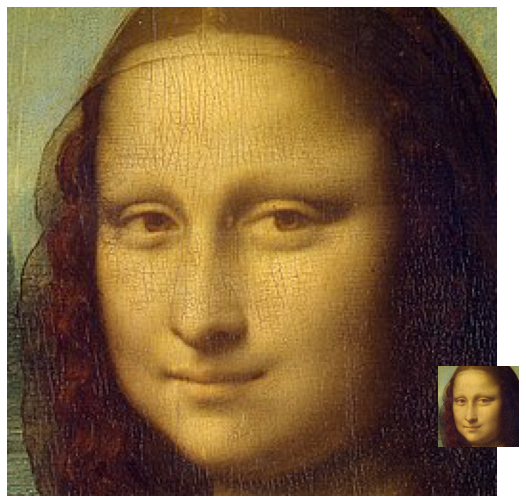

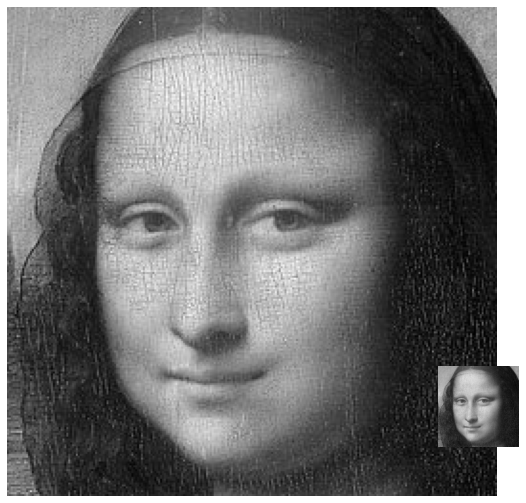

In [25]:
x = 200
y = 125
W = 256
H = 256

face       = mona_lisa_gray[y:(y+H), x:(x+W)]
face_color = mona_lisa_color[y:(y+H), x:(x+W)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.imshow(face_color, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax.set_axis_off()

inset_ax = fig.add_axes([0.8, 0.2, 0.125, 0.125], anchor='NE', zorder=1)
inset_ax.imshow(face_color, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
inset_ax.axis('off')

plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.imshow(face, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax.set_axis_off()

inset_ax = fig.add_axes([0.8, 0.2, 0.125, 0.125], anchor='NE', zorder=1)
inset_ax.imshow(face, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
inset_ax.axis('off')

plt.show()

# Peripheral vision simulation

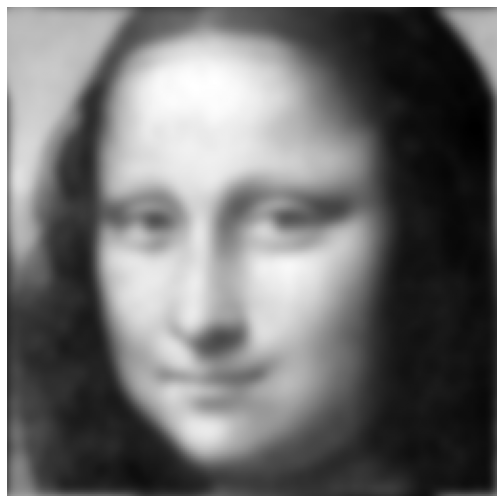

In [13]:
#-----------------------------------------------------------------------------
# simple low pass spatial filtering
#-----------------------------------------------------------------------------
mona_LP = lowPass(face, 14).real

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.imshow(mona_LP, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax.set_axis_off()
plt.show()


# Gaussian and Laplacian image stacks

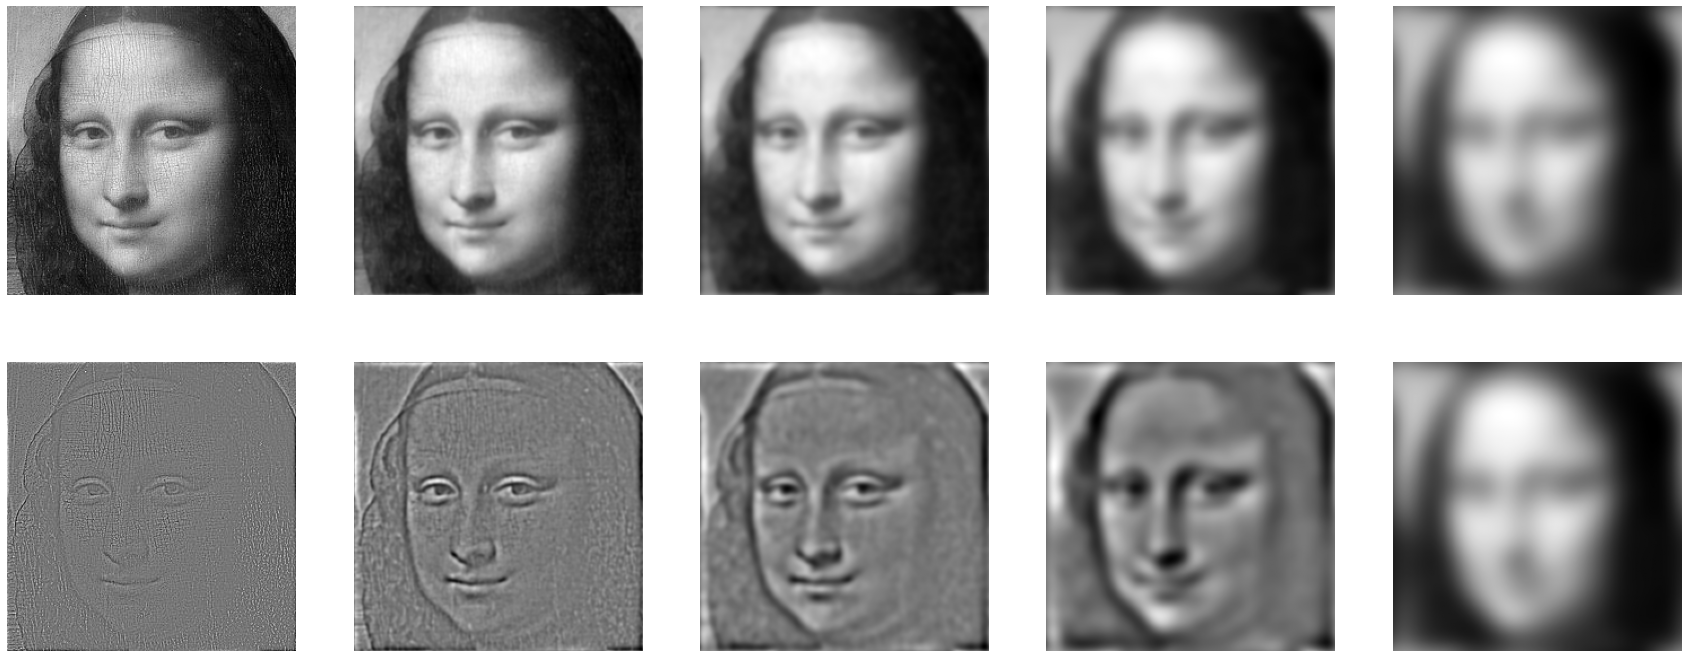

In [14]:
#-----------------------------------------------------------------------------
# Gaussian and Laplacian image stacks - Mona Lisa
#-----------------------------------------------------------------------------
sigmas = [32, 16, 8, 4]
monaG  = stackGaussian(face, sigmas)
monaL  = stackLaplacian(face, sigmas)

N = len(sigmas)+1
fig, ax = plt.subplots(nrows=2, ncols=N, figsize=(N*6,12))
for i in range(0,N):
    ax[0,i].imshow(monaG[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[0,i].set_axis_off()
    ax[1,i].imshow(monaL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[1,i].set_axis_off()
plt.show()

# Reconstruct face
Use the Laplacian stack to reconstruct the face- but leave out some frequency bands

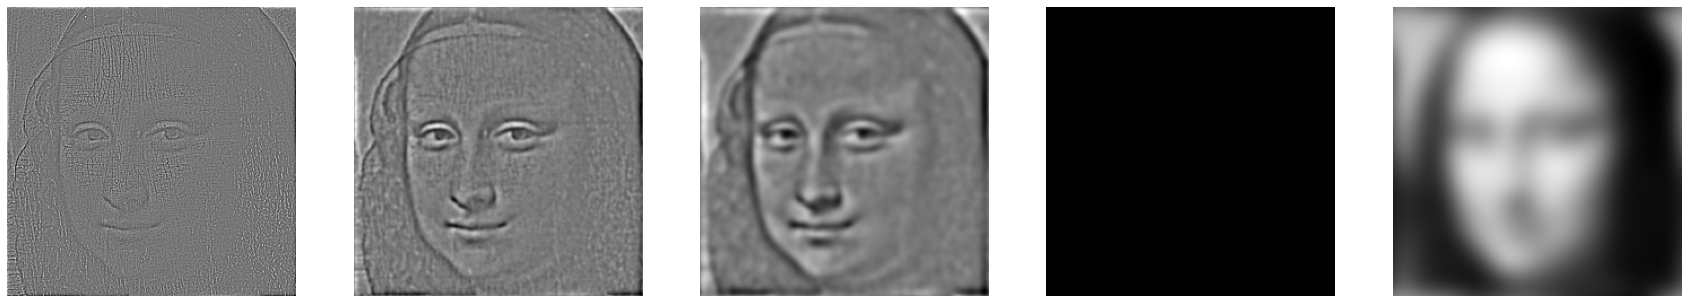

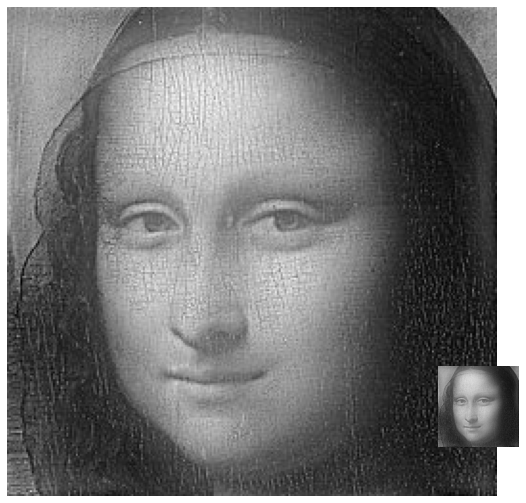

In [26]:
newFace = np.zeros((face.shape[0], face.shape[1]))
w       = [1, 1, 0.5, 0, 1]
for i in range(0, N):
    newFace += w[i]*monaL[i]
    
N = len(sigmas)+1
fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(N*6,12))
for i in range(0,N):
    ax[i].imshow(w[i]*monaL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[i].set_axis_off()
plt.show()

    
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.imshow(newFace, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax.set_axis_off()

inset_ax = fig.add_axes([0.8, 0.2, 0.125, 0.125], anchor='NE', zorder=1)
inset_ax.imshow(newFace, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
inset_ax.axis('off')

plt.show()

# Image blending
The illusive smile of the Mona Lisa utilizes hybrid image techniques- different expressions exists in low and high spatial frequencies. The above image shows this, but simply removing one spatial frequency band effects other facial features besides the mouth. 

Image blending typically applies a Gaussian stack of a binary mask $M$ to smoothly combine the Laplacian stacks of two images ($A$ and $B$) into a composite image $C$. The mask define which regions will be contributed from each image: regions with values of 1 will come from $A$ while regions with values of 0 will come from $B$. In the following equation, the superscript $L$ and $G$ refers to Laplacian and Gaussian stack element, respectively.

$$C^L_k = M^G_k A^L_k + (1-M^G_k)B^L_k$$

In the present case, $B$ is composed from the same Laplacian stack as $A$ except a binary weight $b_k$ determines if element $k$ is used. The composite Laplacian stack equation becomes:

$$B^L_k = b_k A^L_k$$

$$C^L_k = \left[M^G_k + (1-M^G_k)b_k \right] A^L_k$$

## The mask
An ellipse region will be used to define the mouth image blending region, as shown below by superimposing the mask $M$ on the original image (left) and $(1-M)$ on the right.


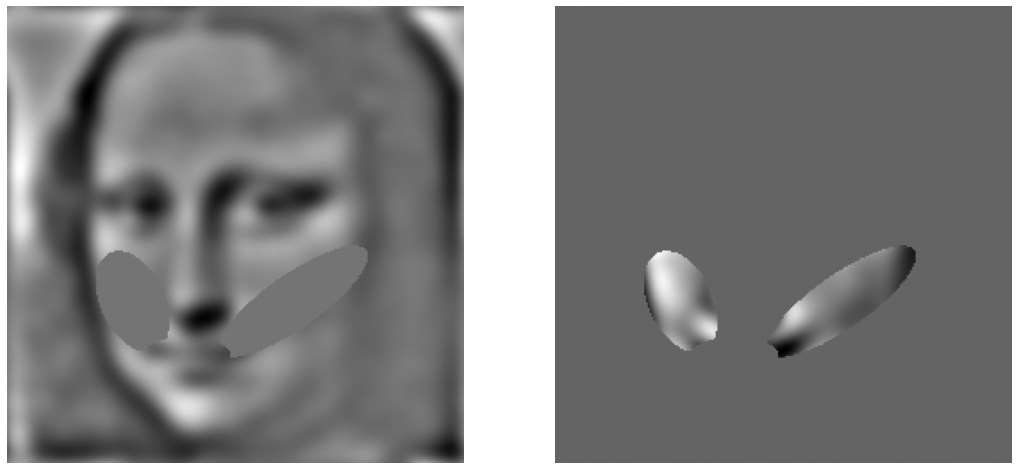

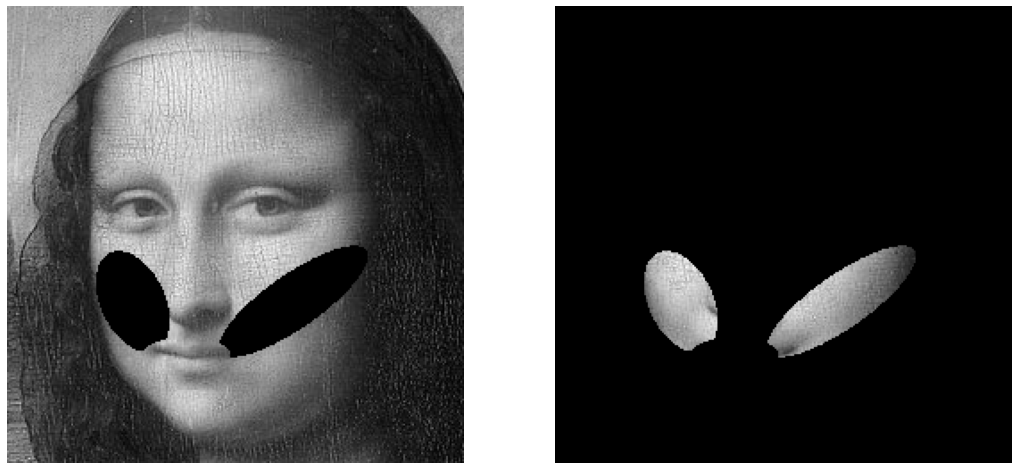

In [28]:
# create the mask from ellipsoidal regions
M         = np.ones_like(face, dtype=np.uint8)

# right portion of smile
#rr, cc    = ellipse(185, 140, 15, 50, rotation=np.deg2rad(30))
rr, cc    = ellipse(165, 160, 15, 50, rotation=np.deg2rad(35))
M[rr, cc] = 0

# left portion of smile
#rr, cc    = ellipse(185, 85, 10, 40, rotation=np.deg2rad(-30))
#rr, cc    = ellipse(165, 65, 10, 40, rotation=np.deg2rad(-30))
rr, cc    = ellipse(165, 70, 18, 30, rotation=np.deg2rad(-65))
M[rr, cc] = 0

# center portion of smile
rr, cc    = ellipse(195, 100, 10, 25, rotation=np.deg2rad(0))
M[rr, cc] = 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,27))
ax[0].imshow(M*monaL[3], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow((1-M)*monaL[3], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,27))
ax[0].imshow(M*face, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow((1-M)*face, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()


## Blended image

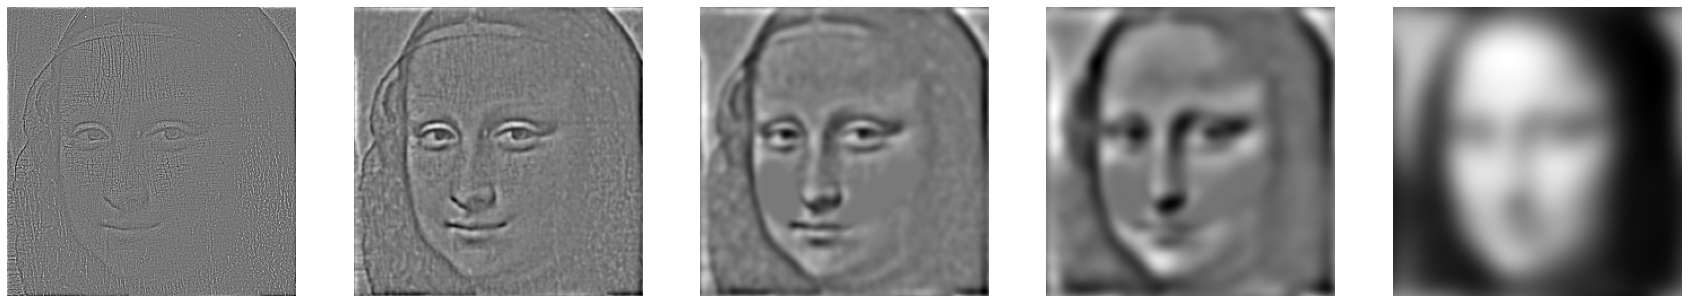

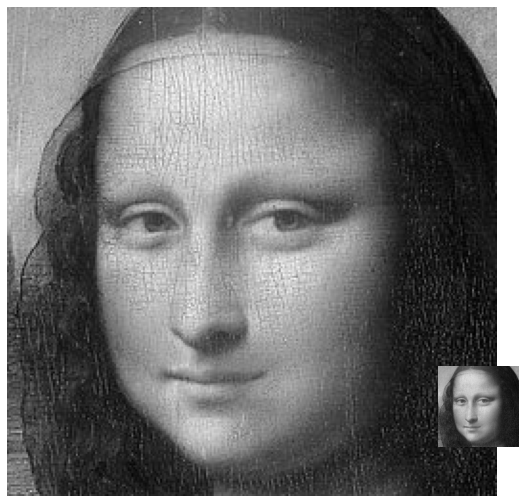

In [29]:
# spectral band weights (last element must be 1)
W   = [1, 1, 0, 0, 1]
Mg  = stackGaussian(M, sigmas)

newFace = np.zeros((face.shape[0], face.shape[1]))
for i in range(0, N):
    newFace += (Mg[i] + (1-Mg[i])*W[i])*monaL[i]
    
N = len(sigmas)+1
fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(N*6,12))
for i in range(0,N):
    ax[i].imshow((Mg[i] + (1-Mg[i])*W[i])*monaL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[i].set_axis_off()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.imshow(newFace, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax.set_axis_off()

inset_ax = fig.add_axes([0.8, 0.2, 0.125, 0.125], anchor='NE', zorder=1)
inset_ax.imshow(newFace, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
inset_ax.axis('off')

plt.show()

# Applying to CK+ facial expression images
Some of the CK+ facial expression dataset images were found here:

https://github.com/spenceryee/CS229/tree/master/CK%2B

A subject (#078) was selected with a happy expression that did not display teeth, similar to the Mona Lisa smile. The neutral and happiness expressions are shown below:


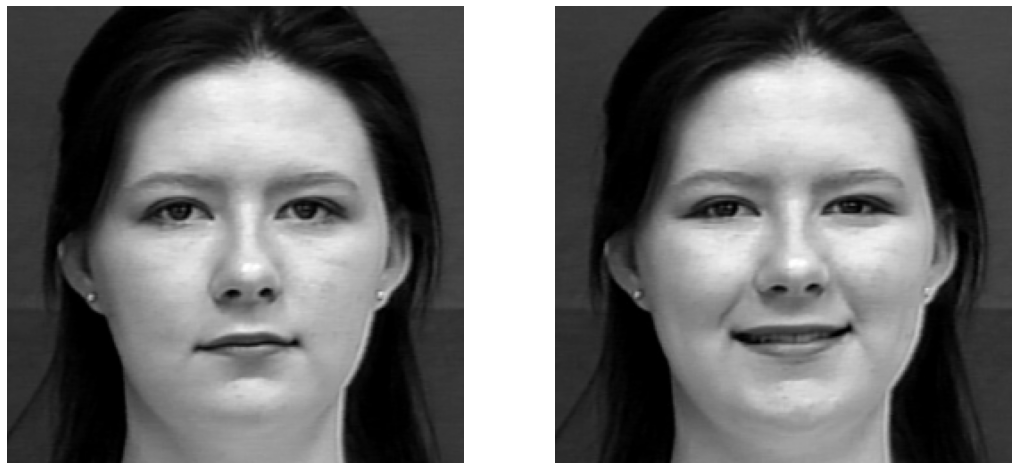

In [30]:
neutral = read_img('S078_001_00000001.png')
neutral = cv2.cvtColor(src=neutral, code=cv2.COLOR_RGB2GRAY)

happy   = read_img('S078_004_00000027.png')
happy   = cv2.cvtColor(src=happy, code=cv2.COLOR_RGB2GRAY)

x = 130
y = 50
a = 350
neutral = neutral[y:y+a, x:x+a]
happy   = happy[y:y+a, x:x+a]
neutral = cv2.resize(neutral, (256,256), interpolation = cv2.INTER_AREA)
happy   = cv2.resize(happy, (256,256), interpolation = cv2.INTER_AREA)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,27))
ax[0].imshow(neutral, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(happy, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()

# Laplacians for S078

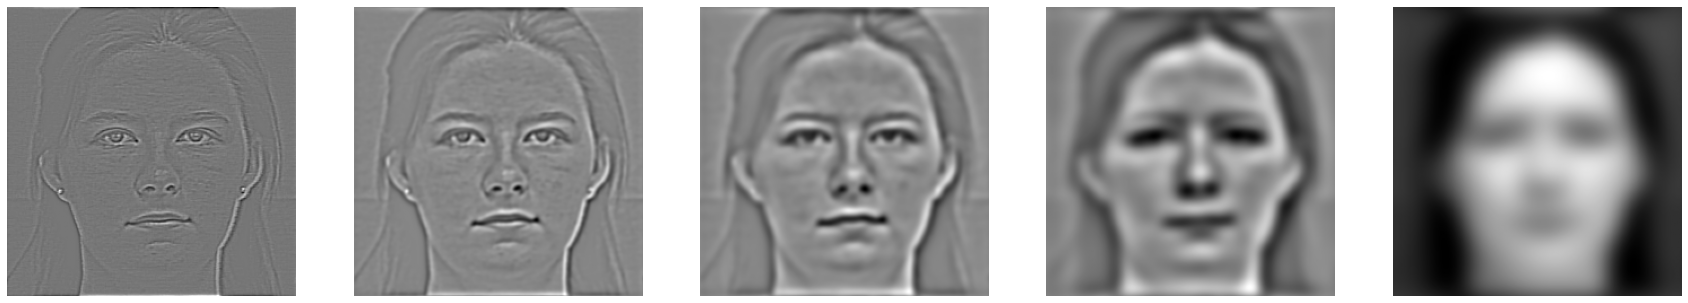

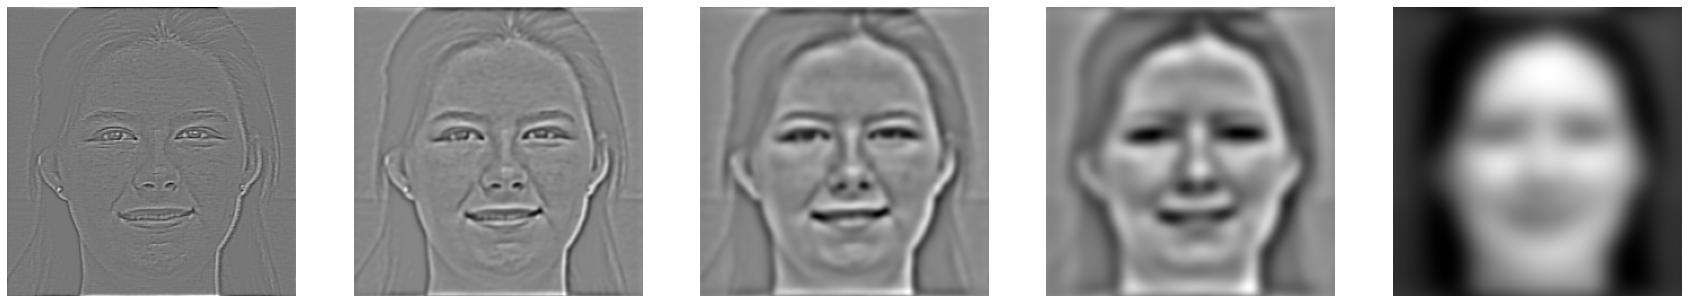

In [31]:
#-----------------------------------------------------------------------------
# Laplacian stacks - S078
#-----------------------------------------------------------------------------
neutralL = stackLaplacian(neutral, sigmas)
happyL   = stackLaplacian(happy, sigmas)

N = len(sigmas)+1
fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(N*6,9))
for i in range(0,N):
    ax[i].imshow(neutralL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[i].set_axis_off()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=N, figsize=(N*6,9))
for i in range(0,N):
    ax[i].imshow(happyL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[i].set_axis_off()
plt.show()

# Image blending on S078
Maskless image blending of Laplacian stacks

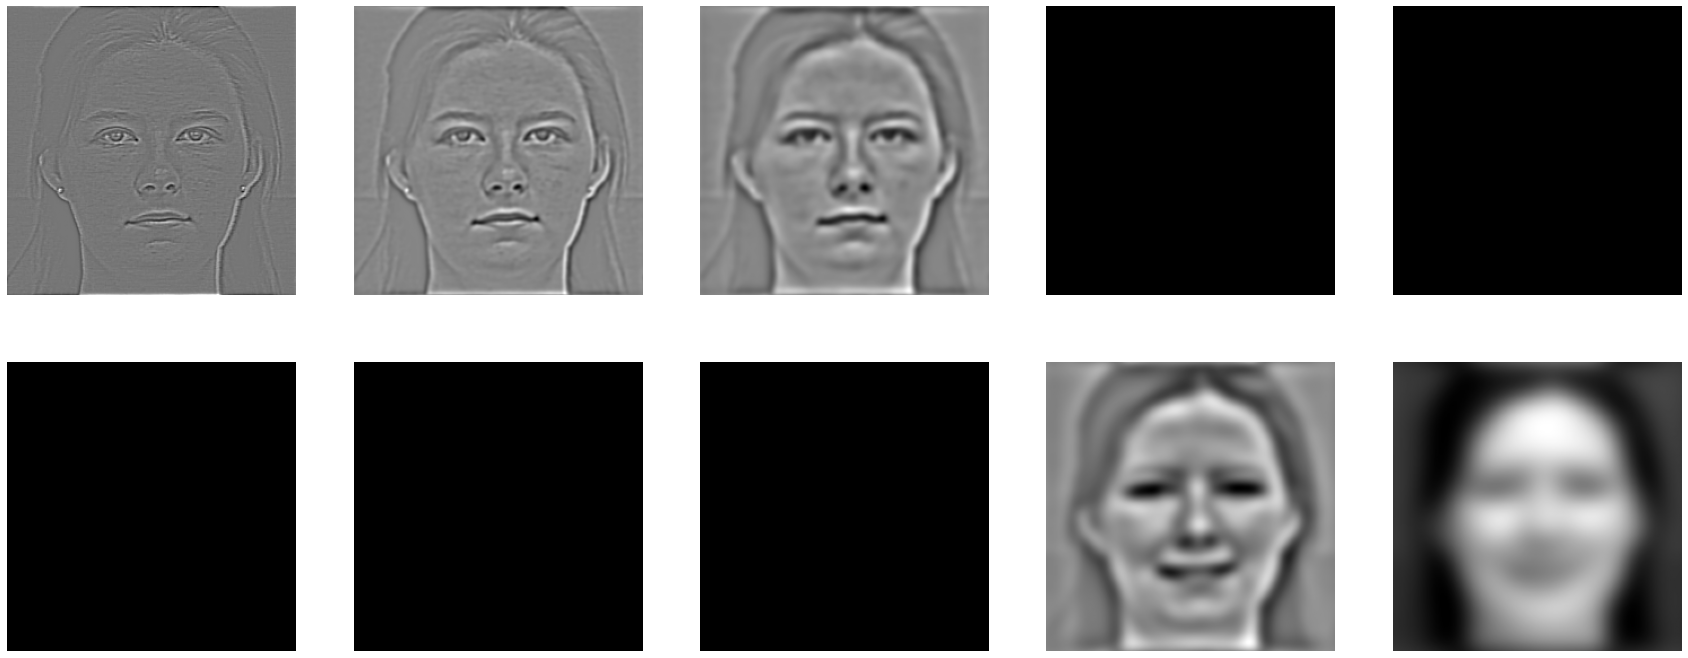

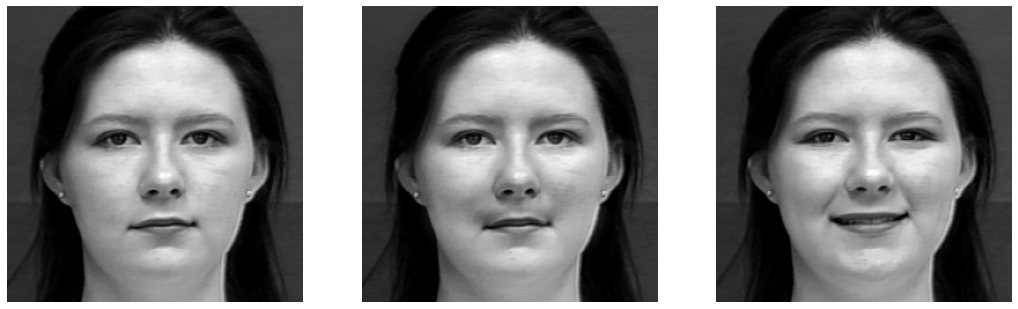

In [33]:
Wn   = [1, 1, 1, 0, 0]
Wh   = [0, 0, 0, 1, 1]

newS078 = np.zeros((neutral.shape[0], neutral.shape[1]))
for i in range(0, N):
    newS078 += Wn[i]*neutralL[i] + Wh[i]*happyL[i]
    
newS078 = exposure.match_histograms(newS078, neutral)
newS078 = cv2.convertScaleAbs(newS078)

N = len(sigmas)+1
fig, ax = plt.subplots(nrows=2, ncols=N, figsize=(N*6,12))
for i in range(0,N):
    ax[0,i].imshow(Wn[i]*neutralL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[0,i].set_axis_off()
    ax[1,i].imshow(Wh[i]*happyL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[1,i].set_axis_off()
plt.show()
    
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
ax[0].imshow(neutral, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(newS078, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
ax[2].imshow(happy, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[2].set_axis_off()
plt.show()

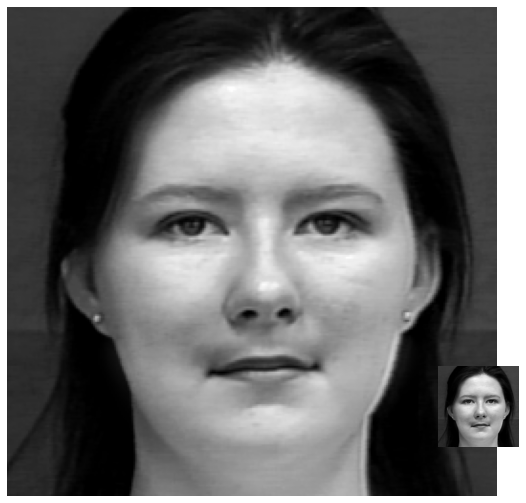

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.imshow(newS078, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax.set_axis_off()

inset_ax = fig.add_axes([0.8, 0.2, 0.125, 0.125], anchor='NE', zorder=1)
inset_ax.imshow(newS078, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
inset_ax.axis('off')

plt.show()

# Image blending S078 with mask

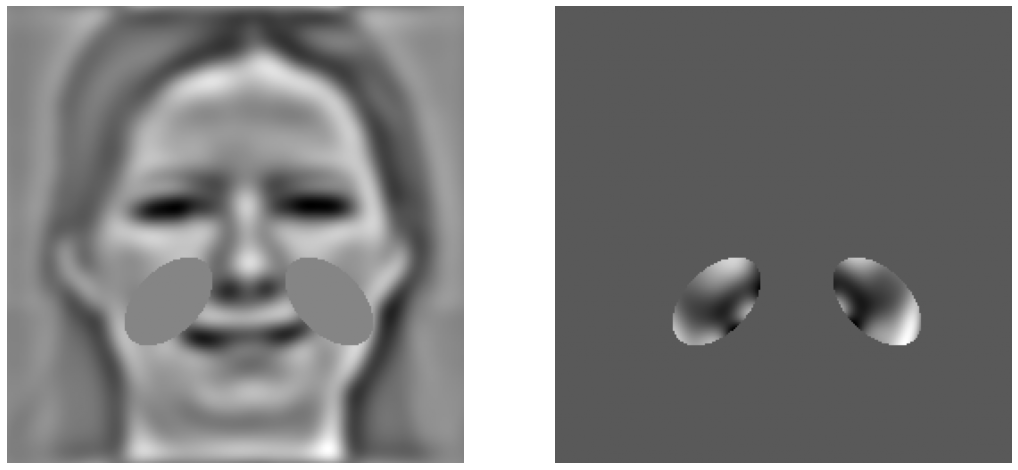

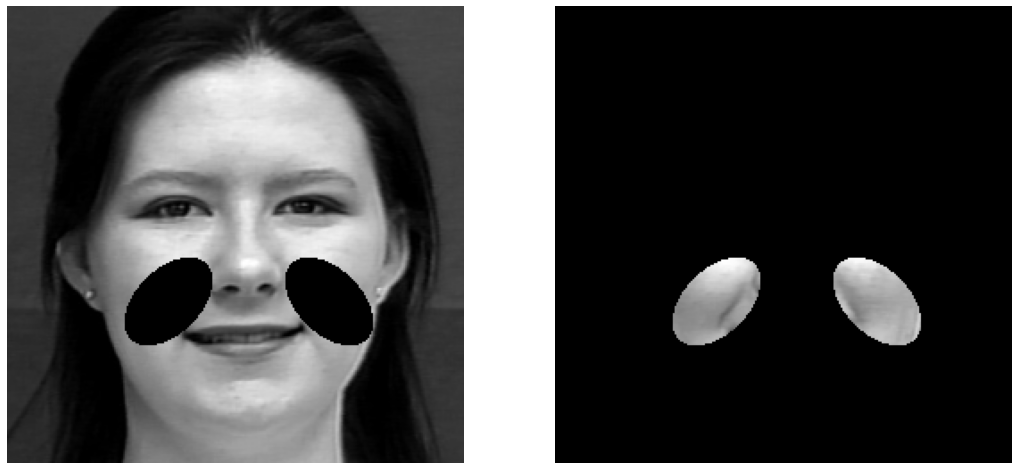

In [34]:
# create the mask from ellipsoidal regions
M         = np.ones_like(neutral, dtype=np.uint8)

# right portion of smile
rr, cc    = ellipse(165, 180, 18, 30, rotation=np.deg2rad(-45))
M[rr, cc] = 0

# left portion of smile
rr, cc    = ellipse(165, 90, 18, 30, rotation=np.deg2rad(45))
M[rr, cc] = 0

# center portion of smile
#rr, cc    = ellipse(195, 100, 10, 25, rotation=np.deg2rad(0))
#M[rr, cc] = 1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,27))
ax[0].imshow(M*happyL[3], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow((1-M)*happyL[3], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,27))
ax[0].imshow(M*happy, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow((1-M)*happy, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
plt.show()

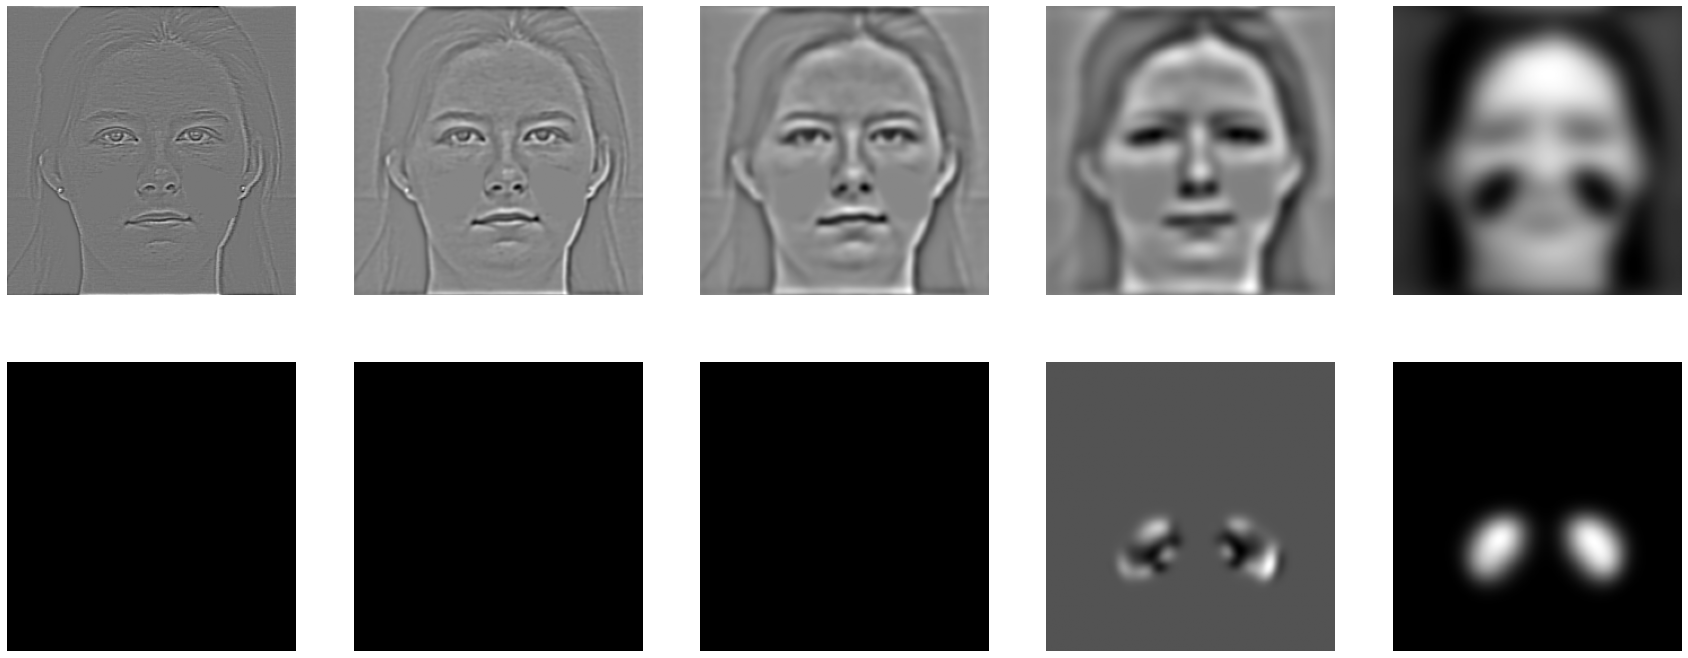

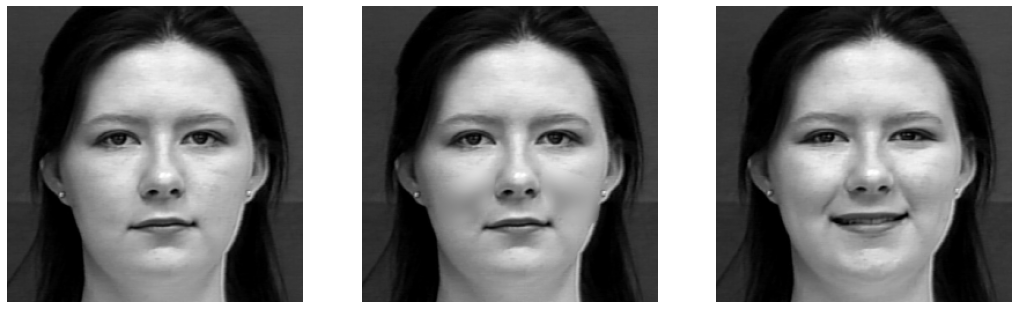

In [36]:
mask078G = stackGaussian(M, sigmas)
Wn   = [1, 1, 1, 1, 1]
Wh   = [0, 0, 0, 1, 1]

newS078m = np.zeros((neutral.shape[0], neutral.shape[1]))
for i in range(0, N):
    newS078m += (mask078G[i])*Wn[i]*neutralL[i] + (1-mask078G[i])*Wh[i]*happyL[i]
    
newS078m = exposure.match_histograms(newS078m, neutral)
newS078m = cv2.convertScaleAbs(newS078m)

N = len(sigmas)+1
fig, ax = plt.subplots(nrows=2, ncols=N, figsize=(N*6,12))
for i in range(0,N):
    ax[0,i].imshow(mask078G[i]*Wn[i]*neutralL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[0,i].set_axis_off()
    ax[1,i].imshow((1-mask078G[i])*Wh[i]*happyL[i], interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
    ax[1,i].set_axis_off()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
ax[0].imshow(neutral, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[0].set_axis_off()
ax[1].imshow(newS078m, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[1].set_axis_off()
ax[2].imshow(happy, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax[2].set_axis_off()
plt.show()

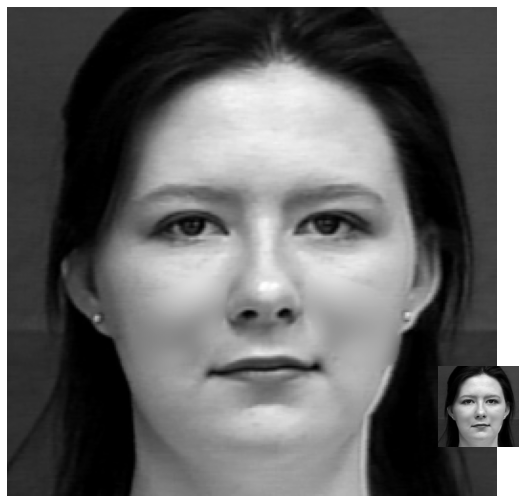

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))
ax.imshow(newS078m, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
ax.set_axis_off()

inset_ax = fig.add_axes([0.8, 0.2, 0.125, 0.125], anchor='NE', zorder=1)
inset_ax.imshow(newS078m, interpolation='antialiased', interpolation_stage='rgba', cmap=plt.cm.gray)
inset_ax.axis('off')

plt.show()